Development of graph coarsening methods

- Get network from OSMNX for random LSOA to MSOA boundary area
- Snap boundary area to OAa and postcodes
- Define function to map nodes in detailed network to new network
- Generate network with OA/postcode centroids as nodes and with 4 layers
    - Big unknown - how to handle layers? Let's look at output of Amsterdam network
- Assign each edge in underlying network to a layer class
    - LTS
    - Based on definitions in paper
- Derive intra-layer links
    - All pairs shortest path
    - Aggregate to coarse network as per definitions in paper

In [35]:
import psycopg2
import pyproj
import geopandas as gpd
import pandas as pd
import random
from shapely.geometry import box, Point
from shapely import wkt
from functools import partial
from shapely.ops import transform
from shapely.ops import split
import ast
from shapely import to_geojson
from geojson_length import calculate_distance, Unit
import networkx as nx
from itertools import product
import heapq
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
from pyproj import Geod

In [2]:
bbx_expansion = 0.5

#Below function from ChatGPT
#Get expanded network - method 1 km buffer
def expand_bbox(original_bbox, expansion_distance_km=5):
    # Create a Shapely geometry object for the original bounding box
    original_geometry = box(*original_bbox)
    # Define a function to project the geometry to a new coordinate reference system
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),  # WGS 84 coordinate reference system
        pyproj.Proj(proj='utm', zone=33, ellps='WGS84')  # Example: UTM Zone 33
    )
    # Project the original geometry to the new coordinate reference system
    projected_geometry = transform(project, original_geometry)
    # Calculate the expansion distance in the projected coordinate system
    expansion_distance_meters = expansion_distance_km * 1000
    # Expand the geometry by the specified distance
    expanded_geometry = projected_geometry.buffer(expansion_distance_meters)
    # Project the expanded geometry back to the original coordinate reference system
    expanded_geometry = transform(partial(pyproj.transform, pyproj.Proj(proj='utm', zone=33, ellps='WGS84'), pyproj.Proj(init='epsg:4326')), expanded_geometry)
    # Get the coordinates of the expanded bounding box
    expanded_bbox = expanded_geometry.bounds
    return expanded_bbox, expanded_geometry

def create_bounding_box(geometry1, geometry2):

    # Calculate the union of all polygons in each multipolygon
    union_geometry1 = geometry1.convex_hull
    union_geometry2 = geometry2.convex_hull
    # Calculate the union of the convex hulls of the two multipolygons
    union_geometry = union_geometry1.union(union_geometry2)
    # Get the bounding box of the union geometry
    bounding_box = union_geometry.bounds
    return bounding_box

def get_edges_from_geom(geom, con, project, table):
    
    # Define your query with a placeholder for the polygon WKT
    query = """
    SELECT r.*, ST_AsText(r.geometry) as geom_str
    FROM import.{} as r
    WHERE ST_Intersects(r.geometry, ST_GeomFromText(%s, 3857));
    """.format(table)
    
    # Execute the query
    with con.cursor() as cursor:
        cursor.execute(query, (transform(project.transform, geom).wkt,))
        results = cursor.fetchall()
        # Get column names
        colnames = [desc[0] for desc in cursor.description]
        
    # Convert results to a DataFrame
    expanded_edges = pd.DataFrame(results, columns=colnames)
    
    # Convert the geometry column to Shapely geometries
    expanded_edges['geometry'] = expanded_edges['geom_str'].apply(wkt.loads)
    
    # Return as a GeoDataFrame
    return gpd.GeoDataFrame(expanded_edges, geometry='geometry').set_crs(3857).to_crs(4326)

def get_dist_metres(line):
    new_dict = {}
    new_dict['geometry'] = ast.literal_eval(to_geojson(line))
    return calculate_distance(new_dict, Unit.meters)

def create_graph(osm_edges):

    #Node Tracking
    seen_coords = set()
    junctions = set()
    coords_to_edges = {}
    coords_ids = {}
    c_id = 0

    #Edge Tracking
    edges_dict = {}
    edge_id = 0

    count_its = 0


    for i,r in osm_edges.iterrows():
        #Get geom points
        #Get length of geom
        count_its += 1
        
        edge_coords = list(r['geometry'].coords)
        num_geoms = len(edge_coords)
        
        u = edge_coords[0]
        remaining_length = r['length']
        remaining_geom = r['geometry']
        edge_index = 1
        
        for coord in edge_coords:    
            dist_to_start = edge_index - 1
            dist_to_end = num_geoms - edge_index
            num_coords_in_geom = edge_coords.count(coord)
            
            #If coord is an existing junction in system
            if coord in junctions:
                
                #Check if junction along current edge
                if (dist_to_start > 0) & (dist_to_end > 0) & (num_coords_in_geom == 1):
                    #Split edge
                    split_geom = split(remaining_geom,Point(coord))
                    geom0_prop = get_dist_metres(split_geom.geoms[0]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    geom1_prop = get_dist_metres(split_geom.geoms[1]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    length_geom0 = geom0_prop * remaining_length
                    length_geom1 = geom1_prop * remaining_length
                
                    #Add first part of edge to edges
                    v = coord
                    edge_features = {}
                    edge_features['source'] = coords_ids[u]
                    edge_features['destination'] = coords_ids[v]
                    edge_features['length'] = length_geom0
                    edge_features['oneway'] = r['oneway']
                    edge_features['lts'] = r['lts']
                    edge_features['geometry'] = split_geom.geoms[0]
                    edges_dict[edge_id] = edge_features
                    edge_id = max(edges_dict.keys()) + 1
                    
                    #Update tracking matrices for remaining part of edge
                    u = v
                    remaining_length = length_geom1
                    remaining_geom = split_geom.geoms[1]
                
            #First time seeing a repeated coord which is not in self same edge - class this as a junction  
            elif (coord in seen_coords) & (num_coords_in_geom == 1):
                
                #Add node to junctions
                junctions.add(coord)
                
                #Check if intersection
                if (dist_to_start > 0) & (dist_to_end > 0):
                    #Split edge
                    split_geom = split(remaining_geom,Point(coord))
                    geom0_prop = get_dist_metres(split_geom.geoms[0]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    geom1_prop = get_dist_metres(split_geom.geoms[1]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    length_geom0 = geom0_prop * remaining_length
                    length_geom1 = geom1_prop * remaining_length
                        
                    v = coord
                    edge_features = {}
                    edge_features['source'] = coords_ids[u]
                    edge_features['destination'] = coords_ids[v]
                    edge_features['length'] = length_geom0
                    edge_features['oneway'] = r['oneway']
                    edge_features['lts'] = r['lts']
                    edge_features['geometry'] = split_geom.geoms[0]
                    edges_dict[edge_id] = edge_features
                    edge_id = max(edges_dict.keys()) + 1
                    
                    #Update tracking matrices for remaining part of edge
                    u = v
                    remaining_length = length_geom1
                    remaining_geom = split_geom.geoms[1]
                
                
                #Retrieve original edge and split if junction
                original_edge_id = coords_to_edges[coord]
                original_edge_dict = edges_dict[original_edge_id]
                geom_to_split_coords = list(original_edge_dict['geometry'].coords)
                coord_from_start = geom_to_split_coords.index(coord)
                coord_from_end = len(geom_to_split_coords) - geom_to_split_coords.index(coord) - 1
                num_coords_in_geom_temp = geom_to_split_coords.count(coord)
            
                if (coord_from_start > 0) & (coord_from_end > 0) & (num_coords_in_geom_temp == 1):
                    
                    split_geom = split(original_edge_dict['geometry'],Point(coord))
                    geom0_prop = get_dist_metres(split_geom.geoms[0]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    geom1_prop = get_dist_metres(split_geom.geoms[1]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    length_geom0 = geom0_prop * original_edge_dict['length']
                    length_geom1 = geom1_prop * original_edge_dict['length']
                    
                    temp_id1 = max(edges_dict.keys()) + 2
                    temp_id2 = max(edges_dict.keys()) + 3
                    
                    #Add edge 1
                    u_temp = geom_to_split_coords[0]
                    v_temp = coord                    
                    edge_features = {}
                    edge_features['source'] = coords_ids[u_temp]
                    edge_features['destination'] = coords_ids[v_temp]
                    edge_features['length'] = length_geom0
                    edge_features['oneway'] = r['oneway']
                    edge_features['lts'] = r['lts']
                    edge_features['geometry'] = split_geom.geoms[0]
                    edges_dict[temp_id1] = edge_features
                    
                    #Update coord references in geom
                    for c in list(split_geom.geoms[0].coords):
                        coords_to_edges[c] = temp_id1
                    
                    
                    
                    #Add edge 2
                    u_temp = coord
                    v_temp = geom_to_split_coords[-1]
                    edge_features = {}
                    edge_features['source'] = coords_ids[u_temp]
                    edge_features['destination'] = coords_ids[v_temp]
                    edge_features['length'] = length_geom1
                    edge_features['oneway'] = r['oneway']
                    edge_features['lts'] = r['lts']
                    edge_features['geometry'] = split_geom.geoms[1]
                    edges_dict[temp_id2] = edge_features

                    #Update coord references in geom
                    
                    for c in list(split_geom.geoms[1].coords):
                        coords_to_edges[c] = temp_id2
                    
                    #Delete original edge
                    del edges_dict[original_edge_id]

            else:
                seen_coords.add(coord)
                coords_to_edges[coord] = edge_id
                coords_ids[coord] = c_id
                c_id += 1
            
            edge_index += 1
        
        #Add remaining edge   
        v = coord
        edge_features = {}
        edge_features['source'] = coords_ids[u]
        edge_features['destination'] = coords_ids[v]
        edge_features['length'] = remaining_length
        edge_features['oneway'] = r['oneway']
        edge_features['lts'] = r['lts']
        edge_features['geometry'] = remaining_geom
        edges_dict[edge_id] = edge_features
        edge_id = max(edges_dict.keys()) + 1
        
    # Construct network

    all_edges = pd.DataFrame(edges_dict).T

    # Initialize an empty directed graph
    G = nx.DiGraph()

    # Iterate over the rows of the DataFrame and add edges to the graph
    for index, row in all_edges.iterrows():
        G.add_node(row['source'], pos=(row['geometry'].coords[0]))
        G.add_node(row['destination'], pos=(row['geometry'].coords[-1]))
        G.add_edge(row['source'], row['destination'], length=row['length'], lts = row['lts'])
        # If the edge is not one-way, add the reverse edge too
        if row['oneway'] == 0:
            G.add_edge(row['destination'], row['source'], length=row['length'], lts = row['lts'])
    

    # Extract nodes with their coordinates
    nodes_data = {
        'node': [],
        'latitude': [],
        'longitude': []
    }

    for node, data in G.nodes(data=True):
        nodes_data['node'].append(node)
        nodes_data['latitude'].append(data['pos'][0])
        nodes_data['longitude'].append(data['pos'][1])

    
    return G,pd.DataFrame(nodes_data),all_edges

def sample_data(data, min_sample, rate=0.1):
    """
    Samples data from the input set based on a variable sampling rate.
    
    Parameters:
    data (list): The input dataset.
    rate (float): The sampling rate for datasets larger than 10.
    
    Returns:
    list: The sampled data.
    """
    set_size = len(data)
    
    if set_size <= min_sample:
        # If the set size is 10 or less, return the entire set
        return data
    else:
        # Calculate the sample size
        sample_size = max(min_sample, int(set_size * rate))
        
        # Sample the data
        sampled_data = random.sample(data, sample_size)
        return sampled_data
    
def mean_of_list(lst):
    return sum(lst)/len(lst)

In [3]:
con = psycopg2.connect(database="ukrn", user="chris", password="NcFc2009P", host="/var/run/postgresql/")
project = pyproj.Transformer.from_proj(pyproj.Proj(init='epsg:4326'),pyproj.Proj(init='epsg:3857'))
project_reverse = pyproj.Transformer.from_proj(pyproj.Proj(init='epsg:3857'),pyproj.Proj(init='epsg:4326'))

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferre

In [4]:
# Import MSOA lookup
msoas = gpd.read_file('data/MSOA_EngWal_Dec_2011_Generalised_ClippedEW_0/Middle_Layer_Super_Output_Areas_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp').to_crs(4326).set_index('msoa11cd')

# Import MSOA 2011 OD data
od_data = pd.read_parquet('data/od_2011.parquet')

#Import LSOAs
lsoas = gpd.read_file('data/LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4_6029841263726194941.gpkg').to_crs(4326)
lsoas = pd.concat([lsoas, lsoas.bounds], axis=1)

#Import lsoa to msoa look up
lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')

lsoas_ids = list(lsoas['LSOA11CD'])

lsoas = lsoas.set_index('LSOA11CD')

/tmp/ipykernel_4445/2646690991.py:12: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')


In [5]:
#Get OA Boundaries

oas = gpd.read_file('data/Output_Areas_Dec_2011_Boundaries_EW_BGC_2022_3211360474256931029.geojson').to_crs(4326)

oa_centroids = []
for i,r in oas.iterrows():
    oa_centroids.append(r['geometry'].centroid)
    
oas['centroid'] = oa_centroids

oa_centroids = gpd.GeoDataFrame(oas[['OA11CD','centroid']], geometry='centroid')

oa_centroids = oa_centroids.set_index('OA11CD')
oas = oas.set_index('OA11CD')

In [7]:
lsoa_id = random.sample(lsoas_ids, 1)[0]

In [8]:
lsoa_info = lsoas.loc[lsoa_id]
lsoa_lookup = lookup[lookup['LSOA11CD'] == lsoa_id][:1]

features_append = {}
features_append['lsoa'] = lsoa_id

expanded_bbox, expanded_geometry = expand_bbox((lsoa_info['minx'], lsoa_info['miny'], lsoa_info['maxx'], lsoa_info['maxy']), expansion_distance_km=bbx_expansion)

#OD Cycle to Work Network
bike_ods = od_data[(od_data['geo_code1'] == lsoa_lookup['MSOA11CD'].values[0]) & (od_data['bicycle'] > 0)][['geo_code2','bicycle']].set_index('geo_code2')
bike_ods['geometry'] = msoas['geometry']
bike_ods = bike_ods.dropna()
origin_geom = lsoa_info['geometry']
destination_geom = msoas.loc[bike_ods['bicycle'].idxmax()]['geometry']
bounding_box_coords = create_bounding_box(expanded_geometry, destination_geom)
od_bbox = box(bounding_box_coords[0],bounding_box_coords[1],bounding_box_coords[2],bounding_box_coords[3])

#Get 2016 networks
sql = "select r.* from import.rn2016_roads as r join lsoas.lsoas2011 as s ON ST_Intersects(r.geometry, s.shape) and s.lsoa11cd = '{}';".format(lsoa_id)
lsoa_edges_2016 = gpd.read_postgis(sql, con, geom_col = 'geometry').to_crs(4326)
G_lsoa_2016, nodes_lsoa_2016, edges_lsoa_2016 = create_graph(lsoa_edges_2016)

expanded_edges_2016 = get_edges_from_geom(expanded_geometry, con, project, 'rn2016_roads')
G_expanded_2016, nodes_expanded_2016, edges_expanded_2016 = create_graph(expanded_edges_2016)

od_edges_2016 = get_edges_from_geom(od_bbox, con, project, 'rn2016_roads')
G_od_2016, nodes_od_2016, edges_od_2016 = create_graph(od_edges_2016)

#Get 2021 networks
sql = "select r.* from import.rn2021_roads as r join lsoas.lsoas2011 as s ON ST_Intersects(r.geometry, s.shape) and s.lsoa11cd = '{}';".format(lsoa_id)
lsoa_edges_2021 = gpd.read_postgis(sql, con, geom_col = 'geometry').to_crs(4326)
G_lsoa_2021, nodes_lsoa_2021, edges_lsoa_2021 = create_graph(lsoa_edges_2021)

expanded_edges_2021 = get_edges_from_geom(expanded_geometry, con, project, 'rn2021_roads')
G_expanded_2021, nodes_expanded_2021, edges_expanded_2021 = create_graph(expanded_edges_2021)

od_edges_2021 = get_edges_from_geom(od_bbox, con, project, 'rn2021_roads')
G_od_2021, nodes_od_2021, edges_od_2021 = create_graph(od_edges_2021)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

In [9]:
od_polygon = gpd.GeoSeries([od_bbox])
oas_in_area = oa_centroids[oa_centroids.intersects(od_polygon.unary_union)]

In [10]:
# Network nodes as points

network_node_points_list = []
for i,r in nodes_od_2021.iterrows():
    network_node_points_list.append(Point([r['latitude'],r['longitude']]))
    
network_node_points = gpd.GeoDataFrame(geometry=network_node_points_list)

nodes_od_2021['geometry'] = network_node_points_list
nodes_od_2021 = gpd.GeoDataFrame(nodes_od_2021, geometry = 'geometry')

In [38]:
area_to_nodes = {}
num_nodes_per_oa = []
for oa in list(oas_in_area.index):
    oa_geom = gpd.GeoSeries([oas.loc[oa]['geometry']])
    oa_nodes = nodes_od_2021[nodes_od_2021.intersects(oa_geom.unary_union)]
    area_to_nodes[oa] = oa_nodes
    num_nodes_per_oa.append(len(oa_nodes))

In [12]:
#LTS1
lts_1_edges = [(u, v, d) for u, v, d in G_od_2021.edges(data=True) if d.get('lts', 0) <= 1]
G_lts1 = nx.Graph()
G_lts1.add_nodes_from(list(G_od_2021.nodes))
G_lts1.add_edges_from(lts_1_edges)

#LTS2
lts_2_edges = [(u, v, d) for u, v, d in G_od_2021.edges(data=True) if d.get('lts', 0) <= 2]
G_lts2 = nx.Graph()
G_lts2.add_nodes_from(list(G_od_2021.nodes))
G_lts2.add_edges_from(lts_2_edges)

#LTS3
lts_3_edges = [(u, v, d) for u, v, d in G_od_2021.edges(data=True) if d.get('lts', 0) <= 3]
G_lts3 = nx.Graph()
G_lts3.add_nodes_from(list(G_od_2021.nodes))
G_lts3.add_edges_from(lts_3_edges)

#LTS4
lts_4_edges = [(u, v, d) for u, v, d in G_od_2021.edges(data=True) if d.get('lts', 0) <= 4]
G_lts4 = nx.Graph()
G_lts4.add_nodes_from(list(G_od_2021.nodes))
G_lts4.add_edges_from(lts_4_edges)

In [ ]:
# oa to oa
# get paths
# variable sample
# route paths
# vector - path length (if found)
# if size vector > 0
    # add edge
# add distance as mean of path lengths

In [31]:
#Get summaruy stats of system trying to compute

# Spatial coverage of area

# Create a GeoDataFrame
od_box_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[od_bbox])

# Reproject the GeoDataFrame to a suitable UTM zone (automatic selection)
od_box_gdf = od_box_gdf.to_crs(od_box_gdf.estimate_utm_crs())

# Calculate the area in square meters, then convert to square kilometers
area_sq_m = od_box_gdf.geometry.area[0]
area_sq_km = area_sq_m / 1e6

# Calculate the perimeter in meters, then convert to kilometers
perimeter_m = od_box_gdf.geometry.length[0]
perimeter_km = perimeter_m / 1000

# Calculate geodesic distances between diagonal corners using pyproj
geod = Geod(ellps="WGS84")
corners = list(od_bbox.exterior.coords)
# For a quadrilateral, diagonals are between (0, 2) and (1, 3)
diagonals = [(0, 2), (1, 3)]
diagonal_distances_km = []
for i, j in diagonals:
    dist_m = geod.inv(corners[i][0], corners[i][1], corners[j][0], corners[j][1])[2]
    dist_km = dist_m / 1000
    diagonal_distances_km.append(dist_km)

# Output the summary statistics
print(f"Area: {area_sq_km:.2f} square kilometers")
print(f"Perimeter: {perimeter_km:.2f} kilometers")
print("Diagonal distances between corners (in kilometers):")
for d in diagonal_distances_km:
    print(f"{d:.2f}")

In [43]:
# Number of OAs
oas_in_area_list = list(oas_in_area.index)
print('Number of OAs : {}'.format(len(oas_in_area)))

# Average nodes per OA
print('Average nodes per OA : {}'.format(mean_of_list(num_nodes_per_oa)))

Number of OAs : 251
Average nodes per OA : 33.44223107569721


In [49]:
import math
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Distance in kilometers
    distance = R * c
    
    return distance

In [59]:
# Number of routes to compute
routes_calculated = 0
for o in oas_in_area_list:
    for d in oas_in_area_list:
        if o != d:
            origin_nodes = area_to_nodes[o]
            destination_nodes = area_to_nodes[d]
            routes = list(product(area_to_nodes[o]['node'],area_to_nodes[d]['node']))
            sampled_routes = sample_data(routes, 10, rate=0.1)
            routes_calculated += len(sampled_routes)
            
print('Number of routes : {}'.format(routes_calculated))

Number of routes : 6991654


In [ ]:
# Average OD distance


In [14]:
# Define the original layers as MultiGraphs
G_c = nx.DiGraph()
G_c.add_nodes_from(oas_in_area_list)

count_origins = 0

routes_calculated = 0

for o in oas_in_area_list:
    count_origins += 1
    print('---------------------------- NEXT ORIGIN ----------------------------')
    print('origin count : {}'.format(count_origins))
    for d in oas_in_area_list:
        if o != d:
            origin_nodes = area_to_nodes[o]
            destination_nodes = area_to_nodes[d]
            routes = list(product(area_to_nodes[o]['node'],area_to_nodes[d]['node']))
            sampled_routes = sample_data(routes, 10, rate=0.2)
            print(('Number of sampled route : {}').format(len(sampled_routes)))
            routes_calculated += len(sampled_routes)
            
            route_lengths_lts1 = []
            route_lengths_lts2 = []
            route_lengths_lts3 = []
            route_lengths_lts4 = []

            for r in sampled_routes:
                try:
                    route_lengths_lts1.append(nx.shortest_path_length(G_lts1,r[0],r[1],weight = 'length'))
                except:
                    pass

                try:
                    route_lengths_lts2.append(nx.shortest_path_length(G_lts2,r[0],r[1],weight = 'length'))
                except:
                    pass

                try:
                    route_lengths_lts3.append(nx.shortest_path_length(G_lts3,r[0],r[1],weight = 'length'))
                except:
                    pass

                try:
                    route_lengths_lts4.append(nx.shortest_path_length(G_lts4,r[0],r[1],weight = 'length'))
                except:
                    pass
            
            distances = []
            if len(route_lengths_lts1) > 0:
                distances.append(mean_of_list(route_lengths_lts1))
            else:
                distances.append(0)
                
            
            if len(route_lengths_lts2) > 0:
                distances.append(mean_of_list(route_lengths_lts2))
            else:
                distances.append(0)
                
            if len(route_lengths_lts3) > 0:
                distances.append(mean_of_list(route_lengths_lts3))
            else:
                distances.append(0)
                
            if len(route_lengths_lts4) > 0:
                distances.append(mean_of_list(route_lengths_lts4))
            else:
                distances.append(0)            
            
            if sum(distances) > 0:
                G_c.add_edge(o, d, distance=distances)

---------------------------- NEXT ORIGIN ----------------------------
origin count : 1
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled route : 
Number of sampled rout

In [23]:
edge_list = nx.to_pandas_edgelist(G_c)

In [24]:
edge_list

,source,target,distance
0,E00000633,E00000636,"[0, 1531.2974891848312, 920.1688780408455, 920..."
1,E00000633,E00000643,"[0, 1153.18062948434, 630.1544315691734, 630.1..."
2,E00000633,E00000644,"[0, 995.7496714036811, 546.4350100923426, 546...."
3,E00000633,E00000646,"[0, 1520.6867711420587, 1157.739524542397, 115..."
4,E00000633,E00000647,"[0, 1494.196414766356, 904.748662378323, 904.7..."
...,...,...,...
6637,E00174920,E00010657,"[0, 1601.0152559901894, 1616.5800057687927, 16..."
6638,E00174920,E00010993,"[0, 0, 2438.4716629176487, 2438.4716629176487]"
6639,E00174920,E00174904,"[0, 0, 1188.310293875722, 1188.310293875722]"
6640,E00174920,E00174914,"[0, 0, 1142.2848173839932, 1142.2848173839932]"


In [25]:
def assign_weights(J,types):
    #------------------------------------------#
    #input: network with 'distance' attribute and type of risk function to apply
    # output: netowrk with 'distance' and 'risk' attribute
    # assigns risk (or discomfort) attribute to each edge of the network
    # risk is a quadruple of values, just like distance, one relative to each 'street-layer' considered 
    #------------------------------------------#
    if types=='Linear':
        for edge in J.edges:
            beta = [None]*4
            beta[0] = J[edge[0]][edge[1]]['distance'][0]
            beta[1] = J[edge[0]][edge[1]]['distance'][1]*0.66
            beta[2] = J[edge[0]][edge[1]]['distance'][2]*0.33
            beta[3] = 0
            J[edge[0]][edge[1]]['risk'] = beta
    return J

G_c=assign_weights(G_c,'Linear')

In [26]:
def updateParetoFront(new_length, new_risk, best_length_risk_states):
    #------------------------------------------#
    # Input:  dist [int], risk[int], paretoFront [sorted dictionary]
    #output:[bolean] if the new_length and new_dist have been added to the ParetoFront returns True, False otherwise 
    # adds new dist, and new risk if the path is pareto optimal (non dominated) 
    #------------------------------------------#
    
    # Find before and after points on length-axis of relation
    after_idx = best_length_risk_states.bisect_right( new_length );
    before_idx = after_idx - 1;
    after_risk = -1
    before_risk = -1 
    
    # Find associated risks
    keys = best_length_risk_states.keys()
    if after_idx < len(best_length_risk_states):
        after_risk = best_length_risk_states.get(keys[after_idx])
    if before_idx >= 0:
        before_risk = best_length_risk_states.get(keys[before_idx])
       
    # Exclude new path if the shorter path has same or less risk
    if before_risk <= new_risk and not before_risk == -1:
        return False

    # Exclude longer or equal paths with higher risks:
    final_exclude_idx = after_idx
    while(final_exclude_idx < len(best_length_risk_states)):
        risk = best_length_risk_states.get(keys[final_exclude_idx])
        if risk < new_risk:
            break
        final_exclude_idx = final_exclude_idx + 1
    del best_length_risk_states.keys()[after_idx:final_exclude_idx]
    best_length_risk_states[new_length] = new_risk
    
    return True

def compute_pareto_fronts(J, o):
    #------------------------------------------#
    #input:  aggregated network [networkx graph], node [int]
    #output: dictionary of all pareto fronts from node 'o' to all other nodes in the network [dictionary] 
    #this implements the multi-objective optimization criteria on all possible OD pairs from node 'o' to all 
    #other nodes of the network (thus it computes ParetoFronts based on distance and risk criteria)
    #------------------------------------------#

    states_to_explore = []
    best_length_risk_states_for_node = {o : SortedDict({0: 0})}
    
    states_to_explore = []
    cnt = 0
    heapq.heappush(states_to_explore, (0, 0, cnt, { 'distance': 0, 'risk': 0, 'prevstate': None, 'node': o }))
    
    while len(states_to_explore) > 0:
        current_distance, current_risk, dummy, current_state = heapq.heappop(states_to_explore)
        current_node = current_state.get('node')
        
        # Check if the explored path is still part of the optimal length risk curve.
        # Otherwise, discard.        
        best_length_risk_states = best_length_risk_states_for_node.get(current_node)
        if best_length_risk_states.get(current_distance, -1) != current_risk:
            continue
        
        for tt in J.out_edges(current_node):
            next_node = tt[1]
            edge = J[current_state.get('node')][next_node]
            
            best_length_risk_states = best_length_risk_states_for_node.get(next_node, None)
            if best_length_risk_states is None:
                best_length_risk_states = SortedDict()
                best_length_risk_states_for_node[next_node] = best_length_risk_states
            
            # Loop over different network choices for link
            for network_i in range(len(edge['distance'])):
                
                # Compute new length
                edge_length = edge['distance'][network_i]
                if edge_length == 0:
                    continue
                new_length = current_distance + edge_length
                
                # Compute new risk
                edge_risk = edge['risk'][network_i]
                new_risk = current_risk + edge_risk
                
                inserted = updateParetoFront(new_length, new_risk, best_length_risk_states)
                if not inserted:
                    continue
                
                new_state = { 'distance': new_length, 'risk': new_risk, 'prevstate': current_state, 'node': next_node}
                # Remove removed states from states_to_explore
                
                heapq.heappush(states_to_explore, (new_length, new_risk, cnt, new_state))
                cnt = cnt + 1
                
    return best_length_risk_states_for_node

In [362]:
list(oas_in_area['OA11CD'])[100]

'E00168104'

In [371]:
list(oas_in_area['OA11CD'])[50]

'E00069188'

In [366]:
sp = compute_pareto_fronts(G_c,'E00168104')

In [372]:
length_risk_curve = sp.get('E00069188')

SortedValuesView(SortedDict({3829.0368750419448: 204.96347017709837, 3831.0528052612303: 166.09505550069684, 4012.2416262543106: 0}))


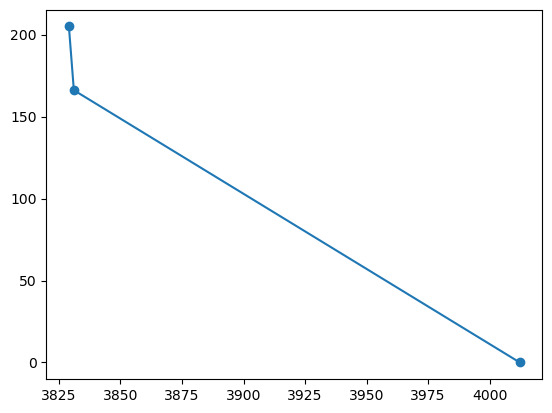

In [373]:

print(length_risk_curve.values())
plt.plot(length_risk_curve.keys(), length_risk_curve.values(), marker='o', linestyle='solid')

In [38]:
# Get random OA
base_oa = random.choice(oas_in_area_list)

# Select 10 random OAs
connected_oas = random.sample(oas_in_area_list, 30)

sp = compute_pareto_fronts(G_c,base_oa)

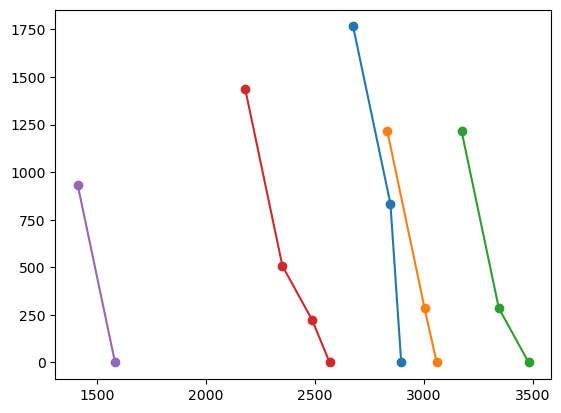

In [39]:
# Plot curves

for i in range(10):

    length_risk_curve = sp.get(connected_oas[i])
    
    if length_risk_curve != None:
    
        if len(length_risk_curve) > 1:
            plt.plot(length_risk_curve.keys(), length_risk_curve.values(), marker='o', linestyle='solid')

plt.show()